# Resident Population in HDB flats

This notebook analyzes the change in resident population in HDB flats from financial years 2008 - 2016

Data URL : https://data.gov.sg/dataset/estimated-resident-population-living-in-hdb-flats

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy.lib.recfunctions as rfn

#set global plot aesthetics
rcParams['axes.titlesize'] = 18
rcParams['axes.titlepad'] = 15
rcParams['axes.labelsize'] = 14
rcParams['axes.labelpad'] = 10
rcParams['axes.labelsize'] = 12

%matplotlib inline

In [2]:
#read data file and get preliminary information about dataset

file1 = "data/estimated-resident-population-in-hdb-flats-by-town.csv"

title = "Estimated resident population in HDB flats"
print("***{}***".format(title))
print()

data = np.genfromtxt(file1, skip_header=1, dtype=[('year','i8'), ('town','U50'),('population','i8')], 
                     delimiter=",",missing_values=['na','-'],filling_values=[0])

num_records = len(data)
unique_entries = np.unique(data['town'])
unique_years = np.unique(data['year'])
start = unique_years.min()   # for this analysis, consider the entire date range in the data set, from earliest to latest year
end = unique_years.max()

#unique_entries includes a 'Total'. Get list of unique town names
towns = [town for town in unique_entries if town != "Total"]

print("There are {} records in the data set for financial years {} to {}, covering {} towns. ".
      format(num_records, start, end, len(towns)))

#make sure that the data is sorted by year, then towns for manipulation
data = np.sort(data,axis=0,order=['year','town'])


***Estimated resident population in HDB flats***

There are 243 records in the data set for financial years 2008 to 2016, covering 26 towns. 


## HDB Population from 2008 to 2016

In [3]:
totaldata = data[data['town']=='Total']

print("Overall, resident population in HDB flats increased from {} in {} to {} in {}".
     format(totaldata['population'][totaldata['year']==start][0],start,
            totaldata['population'][totaldata['year']==end][0],end))

Overall, resident population in HDB flats increased from 3020100 in 2008 to 3249900 in 2016


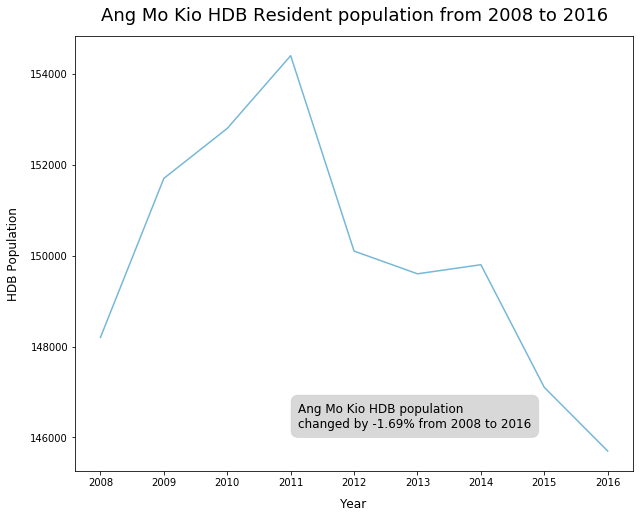

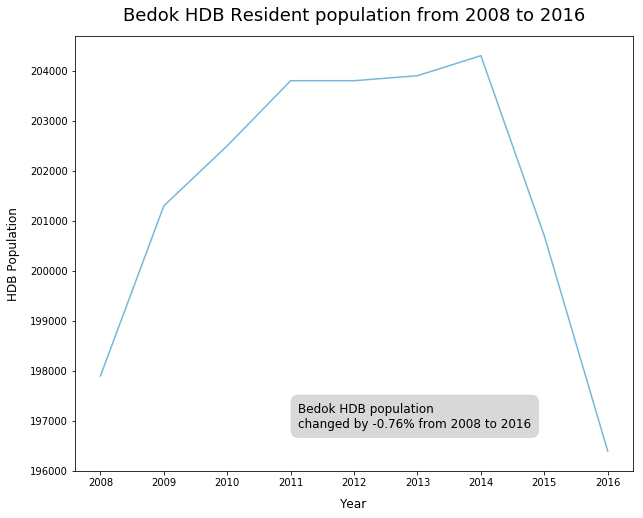

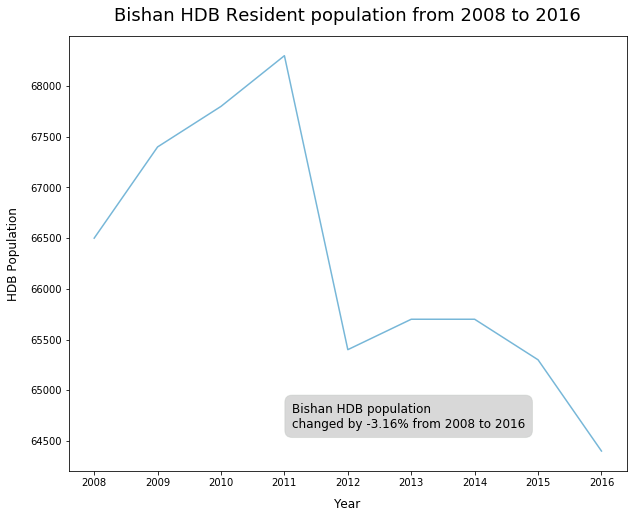

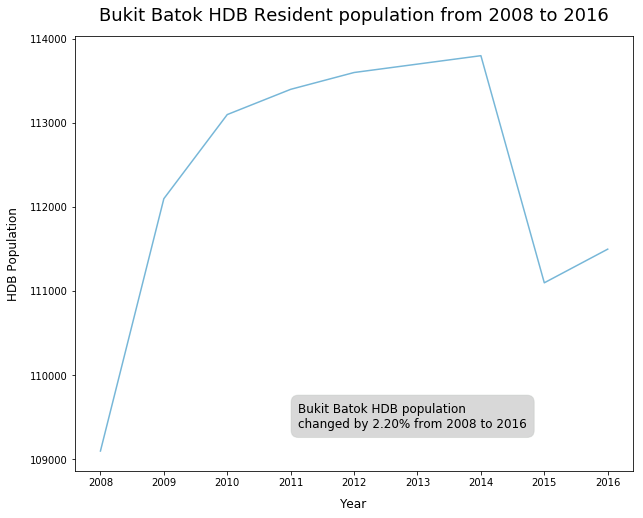

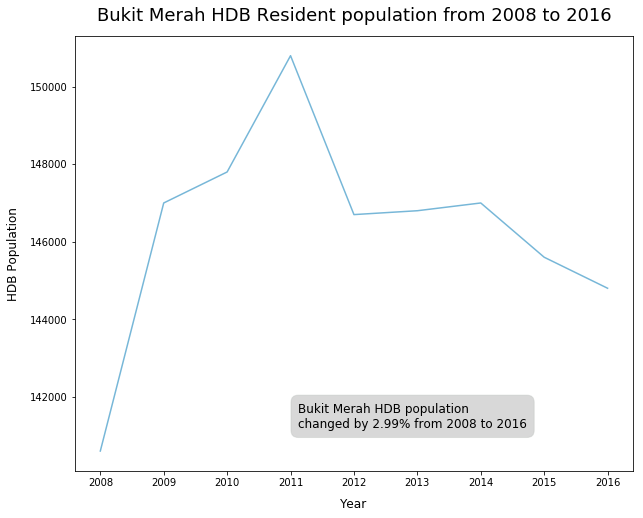

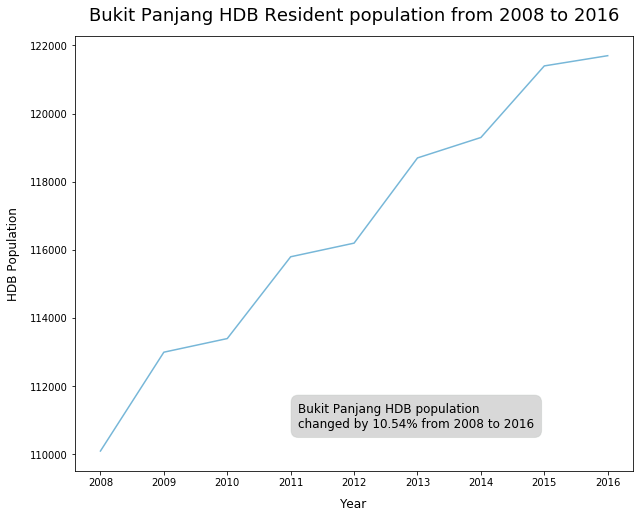

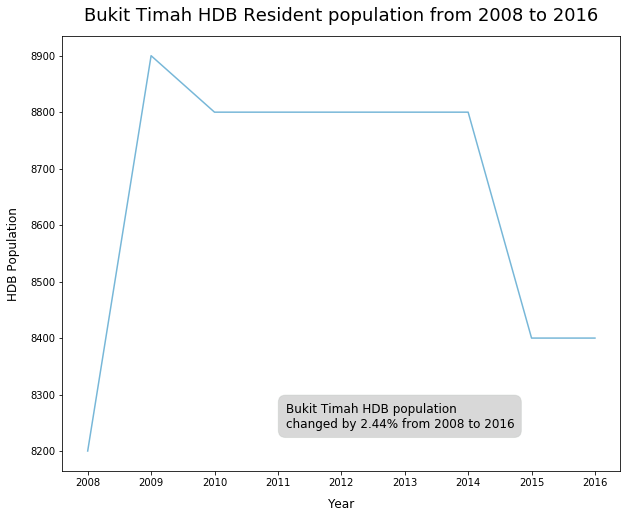

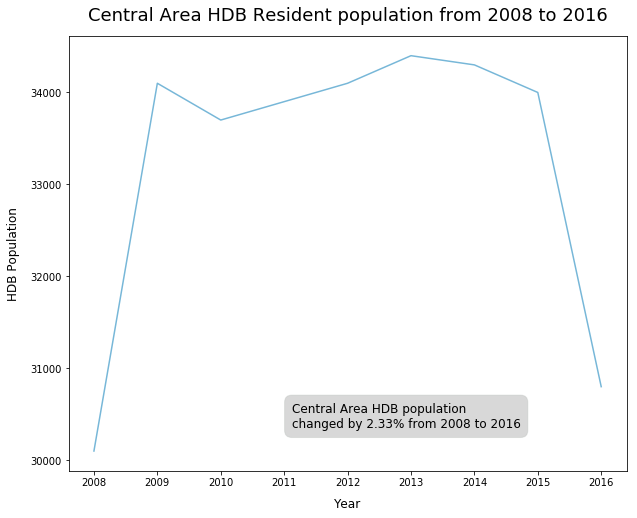

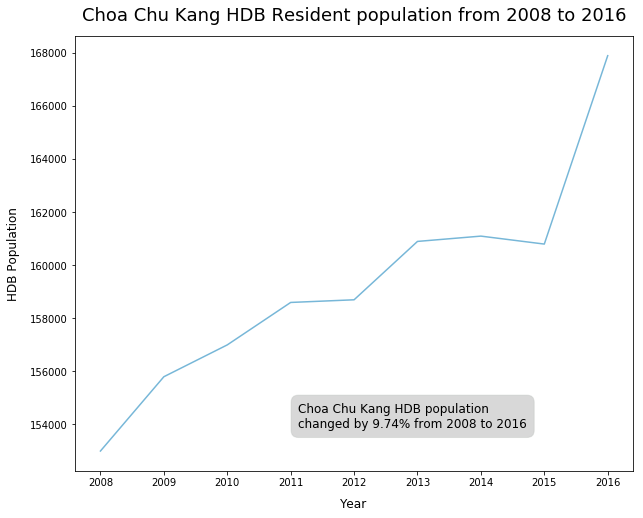

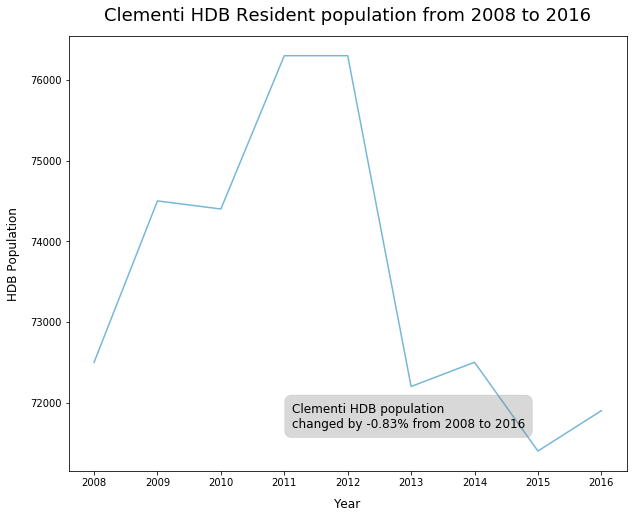

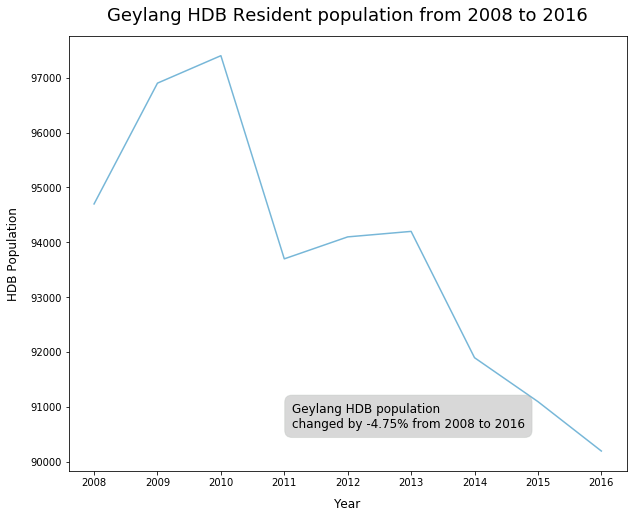

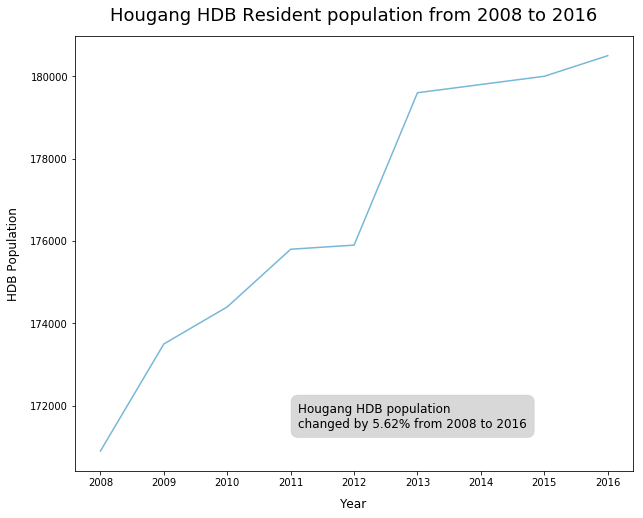

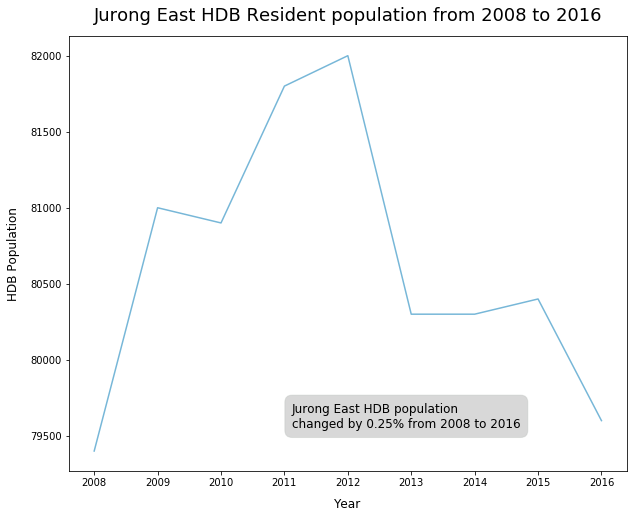

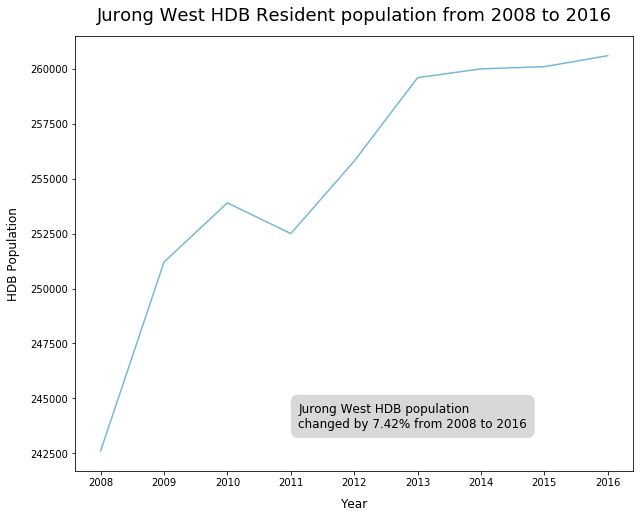

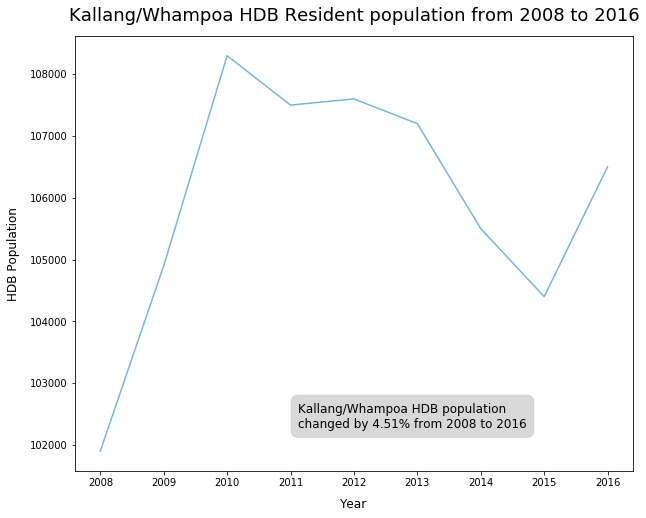

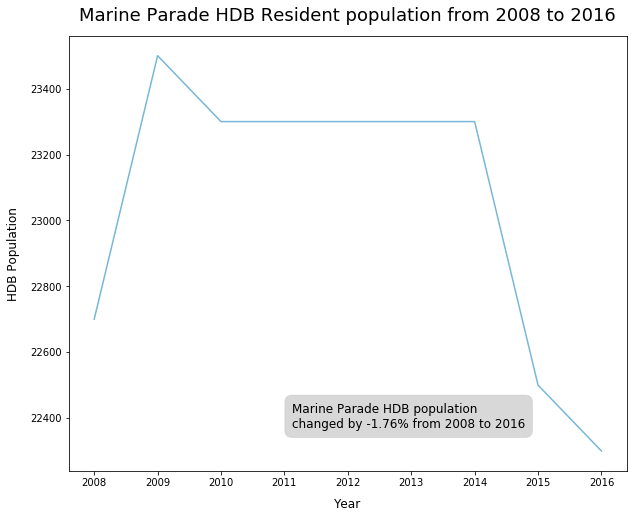

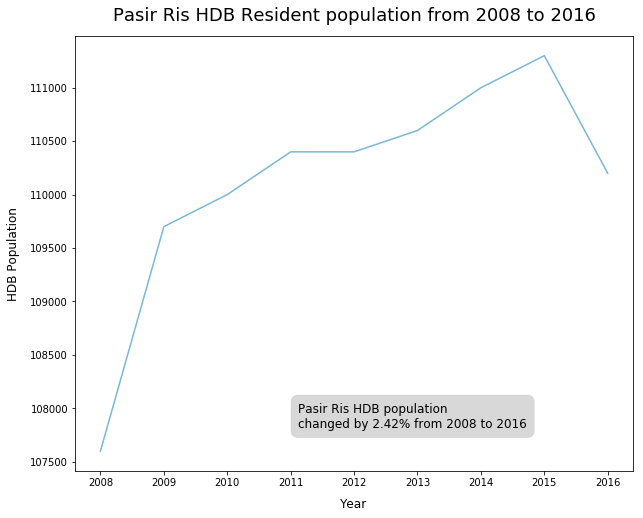

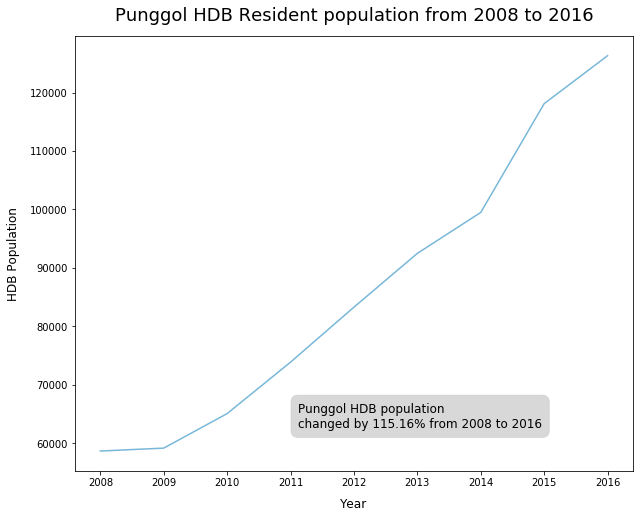

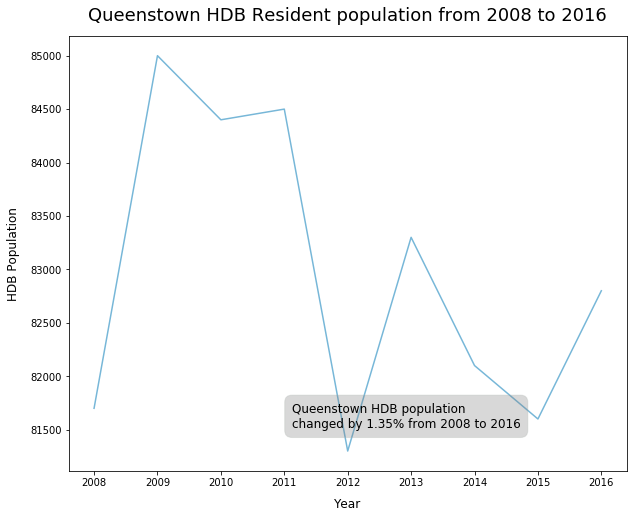

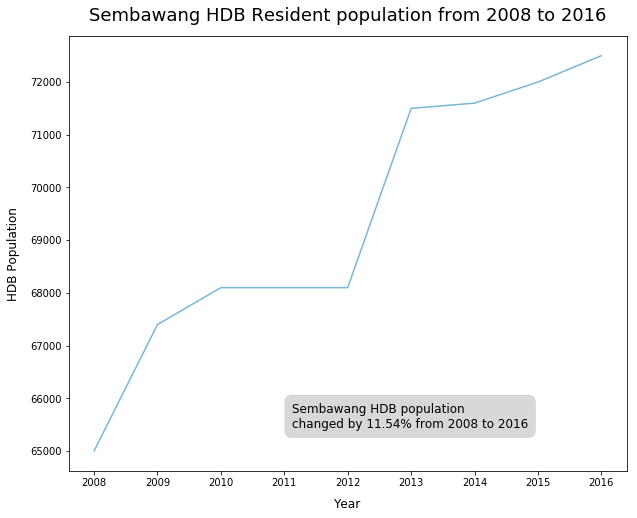

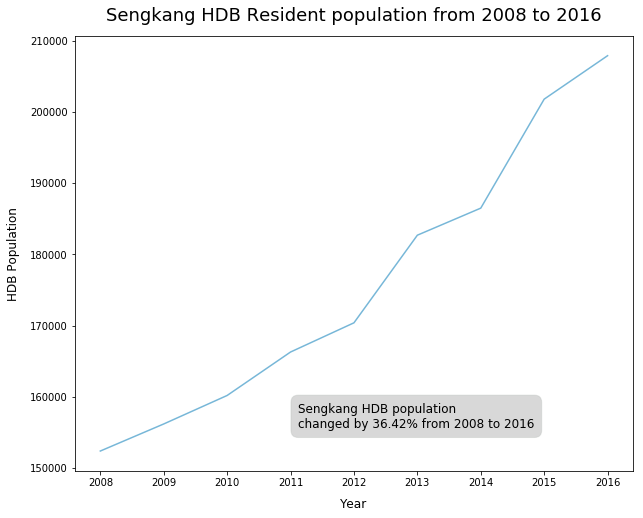

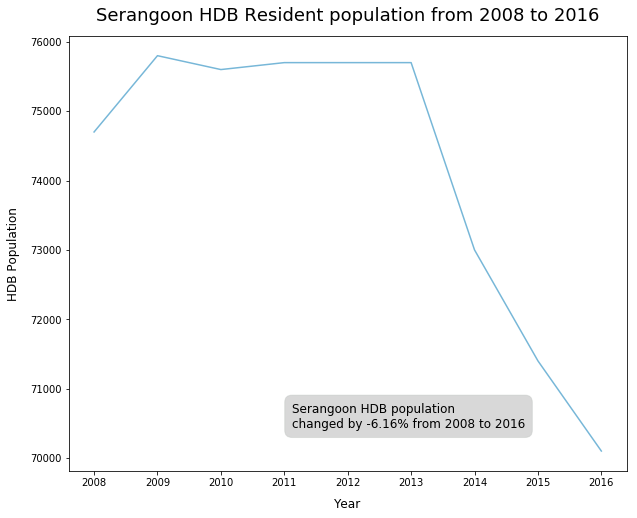

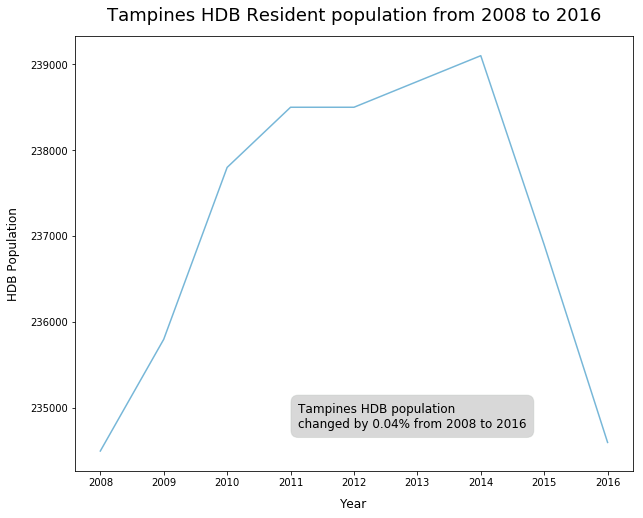

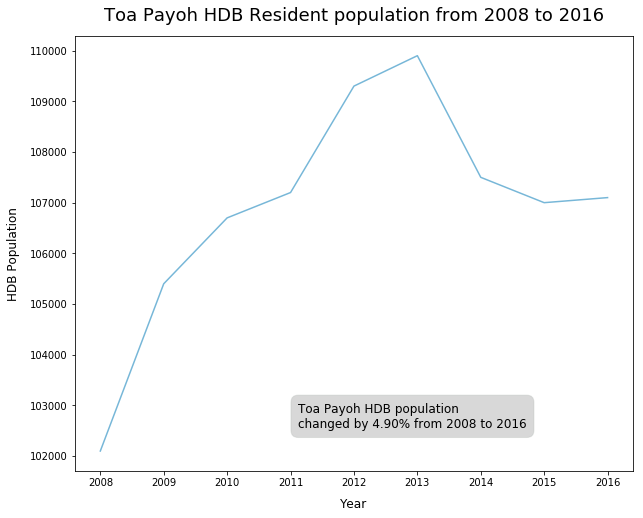

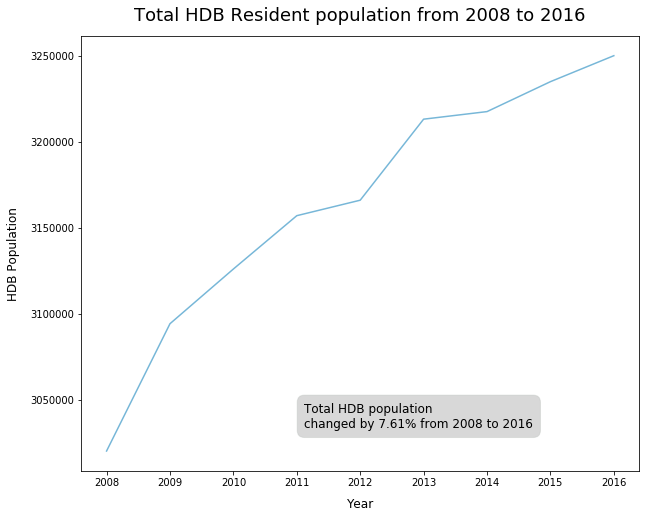

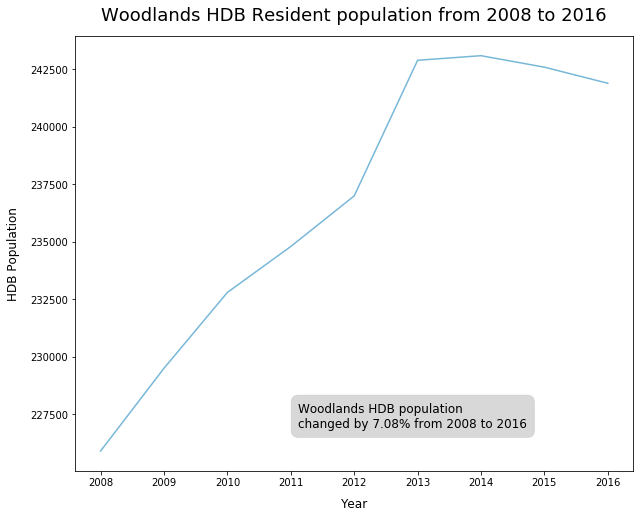

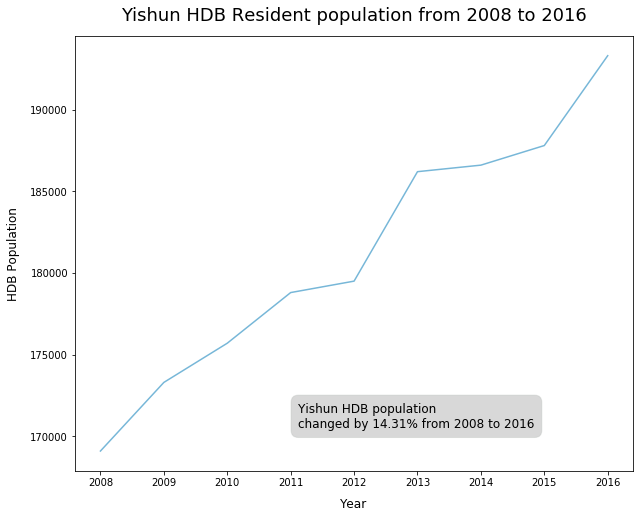

In [4]:
#define function to create and save line chart that shows resident population for a specified town from a specified start year to end year 
def line_chart_hdbpoptrend(town, data, start_year, end_year):
    
    #subset data to town of interest
    plotdata = data[data['town']==town]
    
    fig,ax = plt.subplots(figsize=(10,8))
    ax.plot(plotdata['year'], plotdata['population'], linewidth=1.5, color = '#77B7D8')
    
    #add labels and annotation
    ax.set_title("{} HDB Resident population from {} to {}".format(town, start_year, end_year))
    ax.set_ylabel("HDB Population")
    ax.set_xlabel("Year")
                  
    #calculate the percent change in population
    popend = plotdata['population'][plotdata['year']==end_year]
    popstart  = plotdata['population'][plotdata['year']==start_year]
    percentchange = 100 * (popend - popstart) / popstart
    
    #display text label on line chart showing % change
    textlabel = "{} HDB population\nchanged by {:.2f}% from {} to {}".format(town, percentchange.item(), start_year, end_year)
    bbox_prop = dict(boxstyle="round, pad=0.6", fc="gray",ec='#AFB6B1', alpha=0.3)
    ax.text(0.4, 0.1, textlabel, transform=ax.transAxes, bbox=bbox_prop, fontsize = 12)
    
    #generate a filename for the town being considered. replace illegal characters
    filename = "generatedplots/"+ town.replace("/","_") + "HDB_pop_trend.png"
    
    #save plot and display
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    
#generate line charts for all towns, including 'Total'
for entry in unique_entries:
    line_chart_hdbpoptrend(entry, data, start, end)

## HDB Population in 2016

In [5]:
#create new array with named columns : town, population in start year, end year and percentchange from start to end year
def getnewarray(data, start_year, end_year):
    
    #create columns of data
    townnames = np.unique(data['town'])
    popstart = data['population'][data['year']==start_year]
    popend= data['population'][data['year']==end_year]
    popchange = 100 * (popend-popstart)/popstart
    
    #merge columns in array
    newarr = rfn.merge_arrays((townnames, popstart, popend, popchange),asrecarray=False, flatten=True)
    
    #rename columns
    labels = ['town','startpop','endpop','change']
    newarr.dtype.names = labels

    return newarr


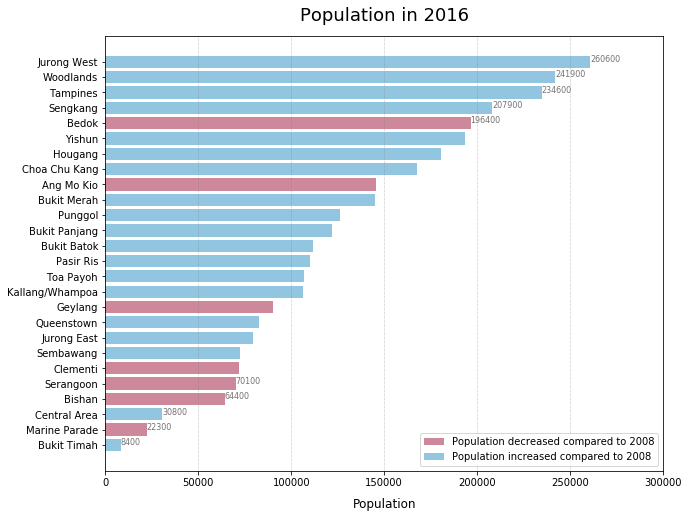

In [6]:
#visualize population at 2016 for all towns and show whether the population increased or decreased

def bar_currentpopulation(data, start, end, filename):
    
    plotdata = getnewarray(data,start,end) #get new array with columns : town, pop at start/end year, and %pop change
    plotdata_sort = np.sort(plotdata, axis = 0, order = 'endpop') #to plot data based on 2016 population ascending order 
    plotdata_sort = plotdata_sort[plotdata_sort['town']!="Total"] #show only individual town populations

    fig, ax = plt.subplots(figsize=(10,8))
    ypos = np.arange(0, len(plotdata_sort))
    
    #split data in 2 sets, one in which population decreased, and the other increased
    x_decrease = plotdata_sort['endpop'][plotdata_sort['change']<0]
    y_decrease = ypos[plotdata_sort['change']<0]
    x_increase = plotdata_sort['endpop'][plotdata_sort['change']>=0]
    y_increase = ypos[plotdata_sort['change']>=0]

    opacity = 0.8

    ax.barh(y_decrease, x_decrease, alpha=opacity, color='#C16C82', label = 'Population decreased compared to {}'.format(start)) 
    ax.barh(y_increase, x_increase, alpha=opacity, color='#77B7D8', label = 'Population increased compared to {}'.format(start)) 

    ax.set_yticks(ypos)
    ax.set_yticklabels(plotdata_sort['town'] )
   
    ax.set_xlabel('Population')
    ax.set_xlim(0,300000)
    
    ax.set_title('Population in 2016')
    ax.grid(color='gray', linestyle=':', linewidth=0.5, axis='x', which='major')
    
    #get 5 highest and 5 lowest populations from the sorted array
    maxval = plotdata_sort['endpop'][-5:]
    maxindex = ypos[-5:]
    minval = plotdata_sort['endpop'][0:5]
    minindex = ypos[0:5]
    
    #show values of 5 highest and 5 lowest populations 
    for index,value in zip(maxindex,maxval):
        ax.text(value,index,value, fontsize = 8, color ='#777274')
    
    for index,value in zip(minindex,minval):
        ax.text(value,index,value, fontsize = 8, color ='#777274')
    
    plt.legend()
    plt.savefig(filename, dpi = 300, bbox_inches='tight')
    plt.show()

    
filename = "generatedplots/"+ "current_population.png"
bar_currentpopulation(data, start, end, filename)

## Population change from 2008 to 2016

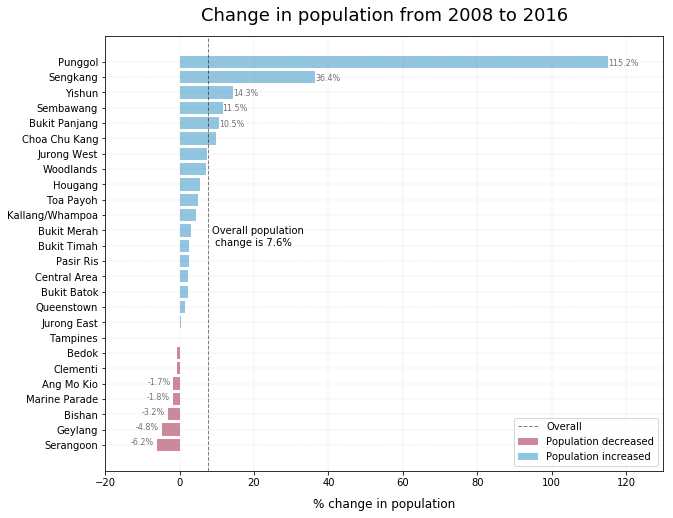

In [7]:
#visualize % population change at 2016 compared to 2008, order it according to % change

def bar_popchange(data, start, end, filename):
    
    plotdata = getnewarray(data,start,end)
    plotdata_sort = np.sort(plotdata, axis = 0, order = 'change') # to plot data based on %pop change in ascending order 
    plotdata_sort = plotdata_sort[plotdata_sort['town']!="Total"] # show values for towns only
    
    fig, ax = plt.subplots(figsize=(10,8))
    
    opacity = 0.8

    ypos = np.arange(0, len(plotdata_sort))
    x_decrease = plotdata_sort['change'][plotdata_sort['change'] < 0]
    y_decrease = ypos[plotdata_sort['change'] < 0]
    x_increase = plotdata_sort['change'][plotdata_sort['change'] >= 0]
    y_increase = ypos[plotdata_sort['change'] >= 0]
    
    decrease = ax.barh(y_decrease, x_decrease, alpha=opacity, color='#C16C82', label = 'Population decreased') 
    increase = ax.barh(y_increase, x_increase, alpha=opacity, color='#77B7D8', label = 'Population increased') 
    
    ax.set_yticks(ypos)
    ax.set_yticklabels(plotdata_sort['town'] )
    ax.set_xlim(-20,130)
    
    # get the values of the largest 5 percentage increase and decrease
    increaseval = plotdata_sort['change'][-5:]
    increaseindex = ypos[-5:]
    decreaseval = plotdata_sort['change'][0:5]
    decreaseindex = ypos[0:5]
    
    # show % values outside the corresponding bar
    for index,value in zip(increaseindex,increaseval):
        ax.text(value,index*0.99,"{:.1f}%".format(value), fontsize = 8, color ='#777274')
    
    for index,value in zip(decreaseindex,decreaseval):
        ax.text(value-7,index*0.99,"{:.1f}%".format(value), fontsize = 8, color ='#777274')
    
    ax.set_xlabel('% change in population')
    ax.set_title('Change in population from 2008 to 2016')
    ax.grid(color='gray', linestyle=':', linewidth=0.2)
    
    #include vertical reference line showing %change for the entire HDB population 
    xref = plotdata['change'][[plotdata['town']=="Total"]]
    xref_label = "Overall population \n change is {:.1f}%".format(xref.item())
    ax.axvline(xref, linewidth = 1, linestyle = '--', color='black', alpha=0.5, label = 'Overall')
    ax.text(xref+1, len(ypos)/2,  xref_label)
    
    plt.legend()
    plt.savefig(filename, dpi = 300, bbox_inches='tight')
    plt.show()

    
filename = "generatedplots/"+ "populationchange.png"
bar_popchange(data,start,end, filename)